In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 

import pickle
from pcygni_5 import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.warn("IntegrationWarning", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
import warnings
warnings.filterwarnings("ignore")

In [3]:
OB = 'OB1'

In [4]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[0]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (x[:,0] > 3300) & (x[:,0] < 22500)

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]

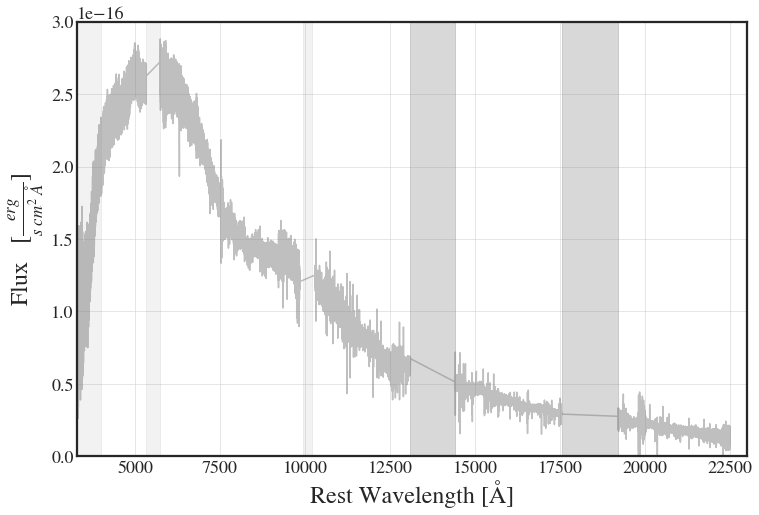

In [5]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2], 
#                 color='grey', alpha=0.9)
plt.ylim(0, 3e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)

In [5]:
from astropy.modeling import models

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653): #blackbody
    #a = 2.0*h*pi*c**2
    #b = h*c/(wav*k*T)
    #intensity = a/ ( (wav**5)*(np.exp(b) - 1.0) )
    intensity = temp(wav, T)
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, tau   , lam, vref=vref, ve=ve , t0=t0)
    #pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    #pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3#*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    #correction = p_cygni_line_corr(wav, v_out, v_phot, tau, lam, vref=vref, ve=ve, t0=t0)
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    #gau1 = models.Gaussian1D.evaluate(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = models.Gaussian1D.evaluate(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    
    lam = v['lam0']
    
    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2, lam = lam)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

beta, doppler = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 

    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**4
        
    #theta = 2*np.sqrt( N*10**(7) /(1-vphot)*corr )#**5)/np.pi ) #regular
    theta = 2*np.sqrt( N*10**(7) / corr )#**5)/np.pi ) #inverse

    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

n_days = [1.427, 2.417, 3.413, 4.403]

In [7]:
@numba.njit(fastmath=True)
def lnprob_inner(model, flux, error):
    return -0.5 * np.sum(((model - flux) / error)**2 + np.log(2 * np.pi * error**2))

def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux, error)

#### Fit structure

In [12]:
p = lmfit.Parameters()
OB = 'OB1'
with open("./data/%s_one_line_init.json"%OB, 'r') as infile:
    p.load(infile)

start = time.time()
mi2 = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
end = time.time()
print('Time elapsed:',(end-start)/60) 

Time elapsed: 0.22363303899765014


In [13]:
lum_dist_arr(mi2.params['N'],mi2.params['vphot'],n_days=1.42), mi2.params['ve'], mi2.params['vphot']

(44.12191976001663,
 <Parameter 've', value=0.3196532921559495, bounds=[0:1]>,
 <Parameter 'vphot', value=0.2859992843739608, bounds=[0:1]>)

In [15]:
mi2.params

name,value,initial value,min,max,vary
T,5429.09785,5436,2500.00000,7500.00000,True
N,1.3492e-29,1.34e-29,-inf,inf,True
vphot,0.28599928,0.28,0.00000000,1.00000000,True
vmax,0.34326171,0.338,0.00000000,1.00000000,True
t0,126000.000,126000,-inf,inf,False
tau,2.03311019,1.69,0.00000000,100.000000,True
vref,0.00000000,0.0,0.00000000,1.00000000,False
ve,0.31965329,0.31,0.00000000,1.00000000,True
occult,0.00649157,0.03,0.00000000,2.00000000,True
amp1,0.27943752,0.28,0.00000000,1.00000000,True


In [16]:
with open("./data/%s_one_line_1.json"%OB, 'w') as outfile:
    mi2.params.dump(outfile)

In [17]:
p = lmfit.Parameters()
with open("./Data/%s_one_line_1.json"%OB, 'r') as infile:
    p.load(infile)

#p
#lum_dist_arr(p['N'],p['vphot'],n_days=2.45), p['ve'], p['vphot']
#p['ve'].value = 0.07
## OB2_1 : fixed ve = [0-0.2]
## OB2_2 : free  ve
p['cen1'].vary=True; p['cen2'].vary=True
p['sig1'].vary=True; p['sig2'].vary=True

p

name,value,initial value,min,max,vary
T,5429.09785,5436,2500.00000,7500.00000,True
N,1.3492e-29,1.34e-29,-inf,inf,True
vphot,0.28599928,0.28,0.00000000,1.00000000,True
vmax,0.34326171,0.338,0.00000000,1.00000000,True
t0,126000.000,126000,-inf,inf,False
tau,2.03311019,1.69,0.00000000,100.000000,True
vref,0.00000000,0.0,0.00000000,1.00000000,False
ve,0.31965329,0.31,0.00000000,1.00000000,True
occult,0.00649157,0.03,0.00000000,2.00000000,True
amp1,0.27943752,0.28,0.00000000,1.00000000,True


In [8]:
pickle_in = open("./data/OB1/OB1_1_line_40x10000.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params

p['lam0'].value = 10456
p['lam0'].vary = False
p

name,value,standard error,relative error,initial value,min,max,vary
T,5423.52997,1.49241522,(0.03%),5429.09784804552,2500.00000,7500.00000,True
N,1.3507e-29,1.7350e-32,(0.13%),1.3491976390739228e-29,-inf,inf,True
vphot,0.29477399,0.00148962,(0.51%),0.2859992843739608,0.00000000,1.00000000,True
vmax,0.37392308,0.00563878,(1.51%),0.34326170527513594,0.00000000,1.00000000,True
t0,126000.000,,(1.51%),126000,-inf,inf,False
tau,1.61888042,0.75663707,(46.74%),2.033110188934817,0.00000000,100.000000,True
vref,0.00000000,,(46.74%),0.0,0.00000000,1.00000000,False
ve,0.30139565,0.12893280,(42.78%),0.3196532921559495,0.00000000,1.00000000,True
occult,0.00115960,0.00330196,(284.75%),0.006491574677289003,0.00000000,2.00000000,True
amp1,0.27724395,0.00655648,(2.36%),0.27943752105569775,0.00000000,1.00000000,True


#### Markov Chain Monto Carlo to sample distribution

In [9]:
mini = lmfit.Minimizer(lnprob, p)

start = time.time()
nwalkers = 50 #v = p.valuesdict()
res2 = mini.emcee(nwalkers=nwalkers, burn=0, steps=3000, thin=1, params=p, seed=12345, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )

100%|██████████| 3000/3000 [1:08:19<00:00,  1.37s/it]  


The chain is shorter than 50 times the integrated autocorrelation time for 13 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [391.39771412 403.85164271  62.92162748  62.61221405 420.72705015
 416.87367856 394.55645134 176.56915495 389.94190307 257.28888138
 122.21633667 323.92813746 242.5197272 ]
Time elapsed [hours]: 1.1407759118080139


In [10]:
flat = res2.flatchain
res2.params


name,value,standard error,relative error,initial value,min,max,vary
T,5438.39355,6.28843554,(0.12%),5423.5299663701035,2500.00000,7500.00000,True
N,1.3290e-29,7.5436e-32,(0.57%),1.3506717604237555e-29,-inf,inf,True
vphot,0.27775986,9.3881e-04,(0.34%),0.29477398701640795,0.00000000,1.00000000,True
vmax,0.33777050,9.2027e-04,(0.27%),0.3739230806186863,0.00000000,1.00000000,True
t0,126000.000,,(0.27%),126000,-inf,inf,False
tau,2.47469314,2.05644249,(83.10%),1.6188804224758078,0.00000000,100.000000,True
vref,0.00000000,,(83.10%),0.0,0.00000000,1.00000000,False
ve,0.22988116,0.09195222,(40.00%),0.30139565057797957,0.00000000,1.00000000,True
occult,0.01134859,0.18254060,(1608.49%),0.001159597903015852,0.00000000,2.00000000,True
amp1,0.30403443,0.01724241,(5.67%),0.2772439502870212,0.00000000,1.00000000,True


In [11]:
(0.27775986 -0.278)/0.29370034

-0.000817636098071932

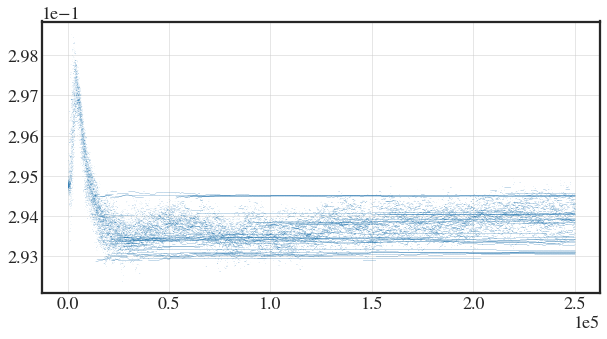

In [19]:
plt.figure(figsize=(10,5))
plt.scatter( np.arange(len(flat['vphot'])), flat['vphot'], s=0.01, alpha=0.1) 


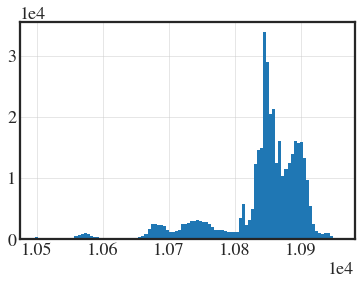

In [22]:
plt.hist(flat['lam0'], bins=100);

In [12]:
with open("./Data/OB1/OB1_1_line_50x3000_lamba0_set_by_4thepoch.pkl", 'wb') as outfile:
    pickle.dump(res2, outfile)

In [77]:
#with open("./Data/OB2/OB2_3_peaks_filtered.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile)

In [36]:
res2.params

name,value,standard error,relative error,initial value,min,max,vary
T,5423.52997,1.49241522,(0.03%),5429.09784804552,2500.00000,7500.00000,True
N,1.3507e-29,1.7350e-32,(0.13%),1.3491976390739228e-29,-inf,inf,True
vphot,0.29477399,0.00148962,(0.51%),0.2859992843739608,0.00000000,1.00000000,True
vmax,0.37392308,0.00563878,(1.51%),0.34326170527513594,0.00000000,1.00000000,True
t0,126000.000,,(1.51%),126000,-inf,inf,False
tau,1.61888042,0.75663707,(46.74%),2.033110188934817,0.00000000,100.000000,True
vref,0.00000000,,(46.74%),0.0,0.00000000,1.00000000,False
ve,0.30139565,0.12893280,(42.78%),0.3196532921559495,0.00000000,1.00000000,True
occult,0.00115960,0.00330196,(284.75%),0.006491574677289003,0.00000000,2.00000000,True
amp1,0.27724395,0.00655648,(2.36%),0.27943752105569775,0.00000000,1.00000000,True


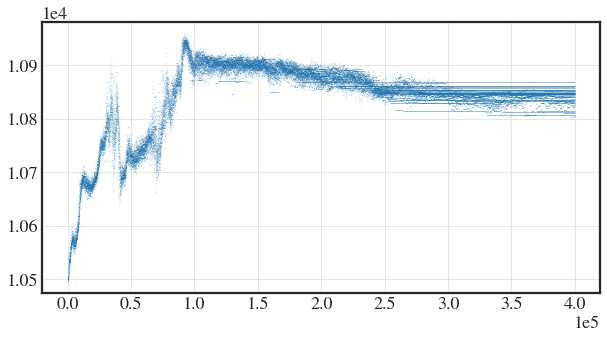

In [27]:
plt.figure(figsize=(10,5))
plt.scatter( np.arange(len(flat['vphot'])), flat['lam0'], s=0.01, alpha=0.1) 


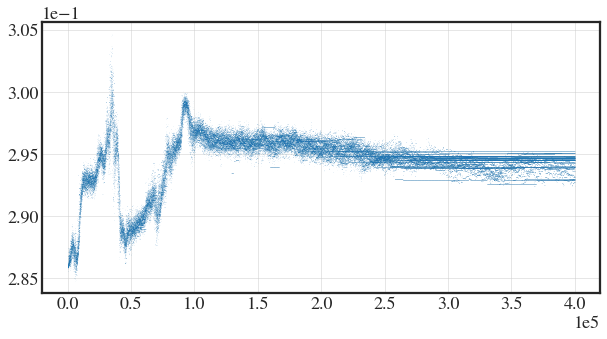

In [21]:
plt.figure(figsize=(10,5))
plt.scatter( np.arange(len(flat['vphot'])), flat['vphot'], s=0.01, alpha=0.1) 


46.11745208163186 46.022004581183715 46.191175974574435


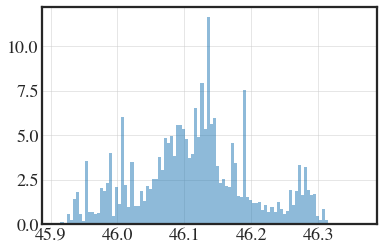

In [23]:
flat = res2.flatchain
#dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=2.42) #* np.sqrt(np.pi)
#plt.hist(dl, bins=100, density=True, alpha=0.5); 
#print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))
#plt.hist(dl, bins=100, density=True, alpha=0.5); 


steady = int(2000*nwalkers)
dl = lum_dist_arr( flat['N'][steady:], flat['vphot'][steady:], n_days=1.43) #* np.sqrt(np.pi)
plt.hist(dl, bins=100, density=True, alpha=0.5); 
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))

In [62]:
res2.params

name,value,standard error,relative error,initial value,min,max,vary
T,3907.81298,2.20307229,(0.06%),3901.684869313191,2500.00000,7500.00000,True
N,2.8767e-29,8.1691e-32,(0.28%),2.901530994172168e-29,-inf,inf,True
vphot,0.26417971,0.00128935,(0.49%),0.26494218465915764,0.00000000,1.00000000,True
vmax,0.29514813,7.2277e-04,(0.24%),0.29538359271367476,0.00000000,1.00000000,True
t0,212400.000,,(0.24%),212400,-inf,inf,False
tau,3.74541811,1.80193230,(48.11%),4.922574068875113,0.00000000,20.0000000,True
vref,0.00000000,,(48.11%),0.0,0.00000000,1.00000000,False
ve,8.58641653,1.33596675,(15.56%),7.077905243169155,0.00000000,10.0000000,True
occult,1.18166550,0.04975578,(4.21%),1.4956418766946291,0.10000000,10.0000000,True
amp1,0.59971709,0.01242183,(2.07%),0.5315972660162986,0.01000000,5.00000000,True


43.04702908840992 42.91479692531522 43.18370582478217


NameError: name 'nwalkers' is not defined

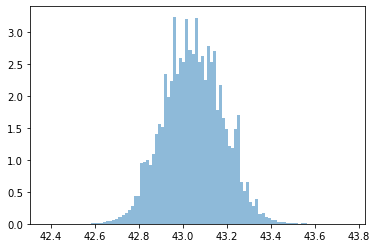

In [10]:
flat = res2.flatchain
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=2.42) #* np.sqrt(np.pi)
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))
plt.hist(dl, bins=100, density=True, alpha=0.5); 


steady = int(800*nwalkers)
dl = lum_dist_arr( flat['N'][steady:], flat['vphot'][steady:], n_days=2.42) #* np.sqrt(np.pi)
plt.hist(dl, bins=100, density=True, alpha=0.5); 
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))

In [32]:
0.00980*c*1e-3/44.9, 0.00980*c*1e-3/45.3

(65.47884187082406, 64.90066225165563)

In [1]:
1.5/29

0.05172413793103448

0.29477398701640795
Lum_dist =  45.2722288367744 + 0.3885924257701774 - 0.3855551356131173
<Parameter 've', value=0.30139565057797957 +/- 0.129, bounds=[0:1]>
1.3506717604237555e-29
0.2556336239971362
Lum_dist =  48.72911909101751 + 0.45185117080556125 - 0.43489477962791767
<Parameter 've', value=3.8259392699450694 +/- 2.22, bounds=[0:10]>
2.678880429450622e-29
46.76739018983268 0.2915885414237825


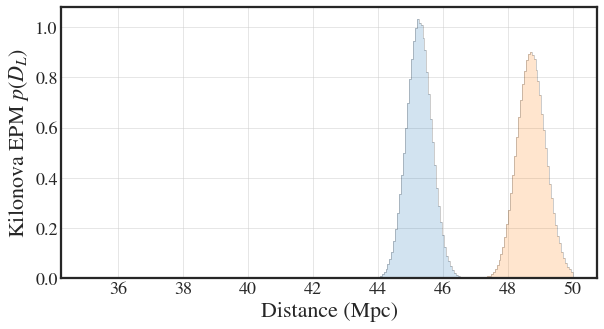

In [8]:
n_days = [1.43, 2.42, 3.42, 4.40, 5.40]

mini = 35
maxi = 50

files = ["./data/OB1/OB1_1_line_40x10000.pkl", "./data/OB2/OB2_1_line_40x10000.pkl"] 
#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
fig,ax = plt.subplots(figsize=(9.6,5))
    
steady = [22*2000, 25*2000, 22*1000, 22*100, 22*3000]

d_m, ds_1, ds_2 = [], [], []
#multi = [0.015, 0.015, 0, 0]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
multi = (0.015**2+np.array([0.005, 0.008, 0.008, 0.008, 0.022])**2)**(1/2)      #dust extinction + flux calibration
#scale = [0, 0, 0.02, 0.02, 0.02]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []

titles = ['1.43 days', '2.42 days', 'Joint']
for idx, file in enumerate(files[:2]):
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    #print(emcee_res.params['T'])
    #print(emcee_res.params['vphot'])
    
    vphot = np.array(emcee_flatten['vphot'])#*np.random.uniform(low=1.422, high=1.438, size=len(emcee_flatten['vphot']))/1.43
    print(np.median(vphot))
    #*np.random.normal(loc=1, scale=scale[idx], size=len(emcee_flatten['vphot']))
        
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])), 
                      vphot, n_days=n_days[idx])[steady[idx]:]
    #dl = dl
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = plt.hist(dl, bins=250, histtype='stepfilled', density=True,
                 label=titles[idx], range=(mini,maxi), alpha=0.2)
    h = plt.hist(dl, bins=250, histtype='step', density=True,
                 range=(mini,maxi), color='k', alpha=0.2)
    temp.append( np.median(emcee_flatten['T']) )
    
    #h = plt.hist(dl, bins=300, histtype='stepfilled', density=True, alpha=0.2, range=(37,47))
    pdf_list.append(h[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    print(emcee_res.params['ve'])
    print(np.median(emcee_flatten['N']))

#fig,ax = plt.subplots(figsize=(8,8))

d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.xlabel(r'Distance (Mpc)'), plt.ylabel(r'Kilonova EPM $p(D_L)$') 
#plt.xlim(35, 47)
#plt.xlim(41.6, 44.6)

sig1 = abs(ds_1+ds_2)/2
sigma = np.sum(1/sig1**2)**(-1/2)
mu = np.sum(1/sig1**2/np.sum(1/sig1**2)*d_m)

print(mu, sigma)

#plt.savefig('Pictures/One_line_D_l.png', dpi=300)

In [7]:
#beta, doppler = np.loadtxt('./codes - Diluted BB/Derivation_conv_Sadun.txt')
#beta, doppler = np.loadtxt('./codes - Diluted BB/Derivation_conv_Udi_full.txt')
beta, doppler = np.loadtxt('./codes - Diluted BB/Derivation_conv_Stuart.txt')

inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    delta = inter(vphot) #v_perp, 1-2/3*11/10*vphot
    corr = delta#/inter2(vphot)**2#**4
        
    theta = 2*np.sqrt( N*10**(7) / corr ) #inverse
    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

In [10]:
np.sqrt(45.3/44.08153188851051)

1.0137264117775815

-0.037923102521732824
Planck -0.05443407494454811 -0.02135976985959608
-0.031699370154558176
Planck -0.0482192064705414 -0.015130558399320166


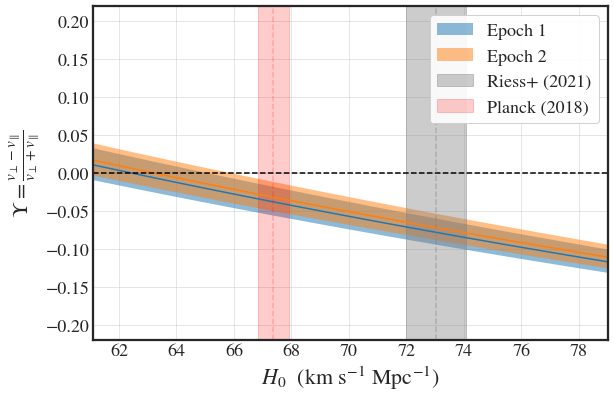

In [51]:
z = 0.00957
H0_p,dH0_p  = 67.36, 0.54
H0_s,dH0_s  = 73.03, 1.04
H0_s1 = np.random.uniform(low=65, high=76, size=np.shape(N_1))

reset_plt(18,22)
plt.figure(figsize=(9,6))
n_days = [1.43, 2.42, 3.42, 4.40, 5.40]

multi = [1.042, 1.042]#[1.0076, 1.0080]#[1.0018, 1.0064]

for i in [0,1]: 
    for idx, file in enumerate([files[i]]):
        pickle_in = open(file,"rb")
        emcee_res = pickle.load(pickle_in)
        emcee_flatten = emcee_res.flatchain
        
        H0_s1 = np.linspace(60, 80, 100)
        dl_s1 = 1/H0_s1*3e5*z*(1+1.53/2*z)
        
        N_1      = np.median( np.array(emcee_flatten['N'])     )
        v_phot_1 = np.median( np.array(emcee_flatten['vphot']) )
        R_1 = np.sqrt( np.array(N_1)*10**7  ) *(dl_s1*3.086e+24)
        v_sn_1 = R_1/n_days[i]/(24*3600*3e10)/inter(v_phot_1)**2
        upsilon_s_1 = (v_sn_1-v_phot_1)/(v_sn_1+v_phot_1)
        upsilon_s_up  = (multi[i]*v_sn_1-v_phot_1)/(multi[i]*v_sn_1+v_phot_1)
        upsilon_s_low = (1/multi[i]*v_sn_1-v_phot_1)/(1/multi[i]*v_sn_1+v_phot_1)

        plt.plot(H0_s1, upsilon_s_1, ls='-')#, s=1, alpha=0.2)

        plt.fill_between(H0_s1, upsilon_s_up*(0.0004+0.00957)/0.00957, #upsilon_s_1*multi[i], #*(-0.0004+0.00957)/0.00957, 
                                upsilon_s_low*(-0.0004+0.00957)/0.00957, #upsilon_s_1/multi[i], #*(0.0004+0.00957)/0.00957, 
                         alpha=0.5, label='Epoch '+str(i+1))#, s=1, alpha=0.2)

        #ups_binned = []
        #for h_0 in np.arange(65, 76): 
        #    ups_binned.append(upsilon_s_1[(H0_s1<(h_0+1)) & (H0_s1>(h_0-1))])
        print(interp1d(H0_s1, upsilon_s_1)(H0_p))
        print('Planck',interp1d(H0_s1, upsilon_s_low)(H0_p-dH0_p), interp1d(H0_s1, upsilon_s_up)(H0_p+dH0_p))
        #print('SNe',interp1d(H0_s1, upsilon_s_1)(H0_sn-dH0_sn), interp1d(H0_s1, upsilon_s_1)(H0_sn+dH0_sn))

#plt.ylim(0.83, 1.17), plt.xlim(65, 76)
#plt.ylim(0.7, 1.3), plt.xlim(60, 80)
plt.ylim(-.22, .22), plt.xlim(61.1, 79.)

plt.axhline(0, ls='--', color='k')
plt.ylabel(r'$\Upsilon = \frac{v_\perp - v_{\parallel}}{v_\perp + v_\parallel}$'), plt.xlabel(r'$H_0$  (km s$^{-1}$ Mpc$^{-1}$)')

H0_sn  = 73.03; dH0_sn = 1.04
plt.axvline(H0_sn, ls='--', color='grey', alpha=0.4)
plt.fill_between([H0_sn-dH0_sn, H0_sn+dH0_sn], [-2, -2], [2, 2], color='grey', alpha=0.4, label='Riess+ (2021)' )

H0_p  = 67.36; dH0_p = 0.54
plt.axvline(H0_p, ls='--', color='red', alpha=0.2)
plt.fill_between([H0_p-dH0_p, H0_p+dH0_p], [-2, -2], [2, 2], color='red', alpha=0.2, label='Planck (2018)' )

plt.ticklabel_format(style='plain')
plt.legend(frameon=True, framealpha=0.9, loc=1, fontsize=18)

#sns.despine(trim=True, offset=20)
#plt.grid(False)

plt.tight_layout()
#plt.savefig('Pictures/Assymetry_H0_8.png', dpi=300)
#plt.savefig('Pictures/One_line_asphericity.png', dpi=300)

In [39]:
np.shape(np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax'], flat['occult'], flat['tau'], flat['ve']]))

(7, 900000)

In [33]:
import corner

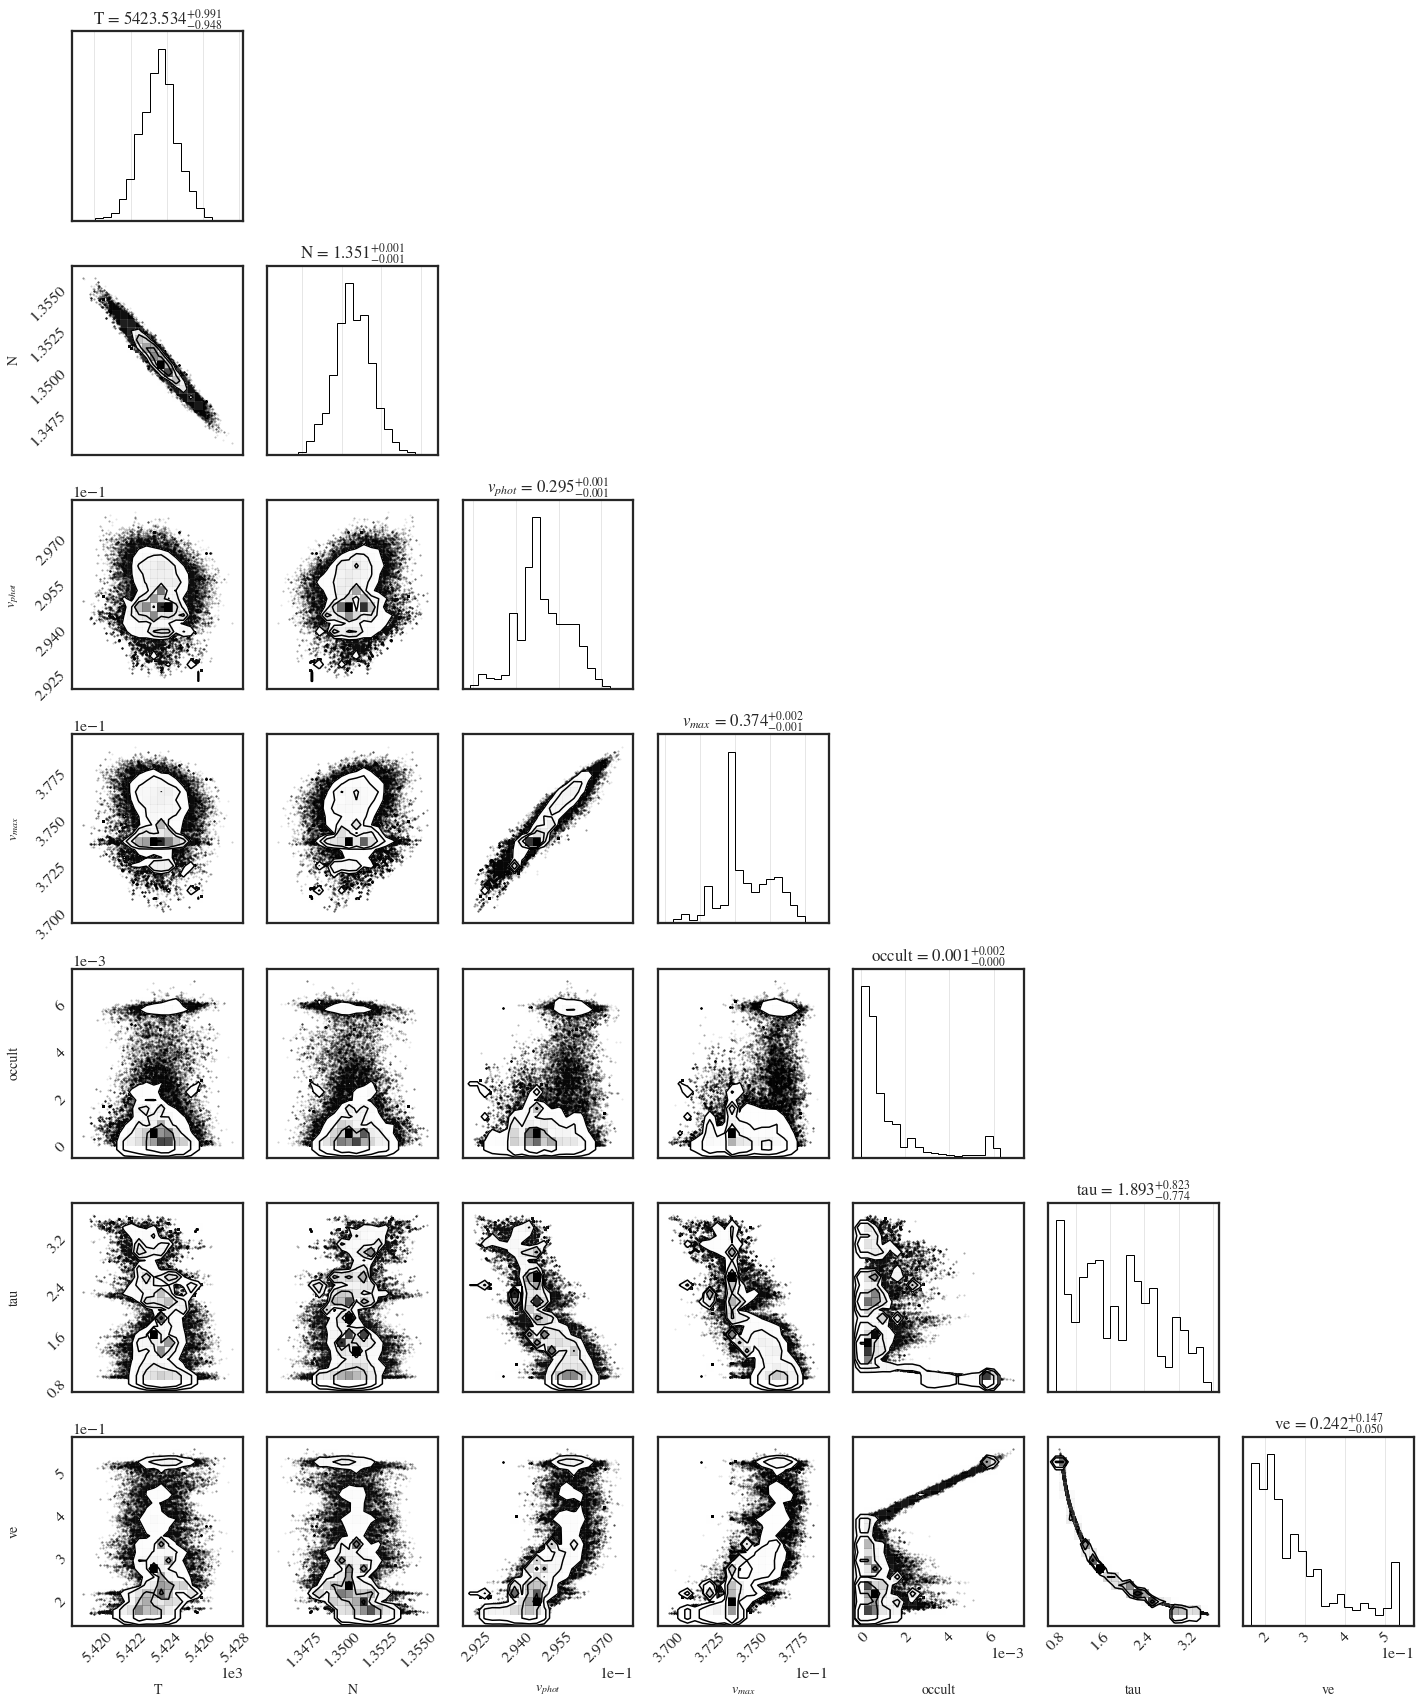

In [34]:
n_box = 7
fig,ax = plt.subplots(figsize=(20,24),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
steady = 3000
reset_plt(16, 14)
corner.corner( np.array([flat['T'][nwalkers*steady:], flat['N'][nwalkers*steady:]*1e29, flat['vphot'][nwalkers*steady:], 
                         flat['vmax'][nwalkers*steady:], flat['occult'][nwalkers*steady:], flat['tau'][nwalkers*steady:], 
                         flat['ve'][nwalkers*steady:]]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$','occult','tau','ve'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB2_covariance_large_filtered_2.png', dpi=300)

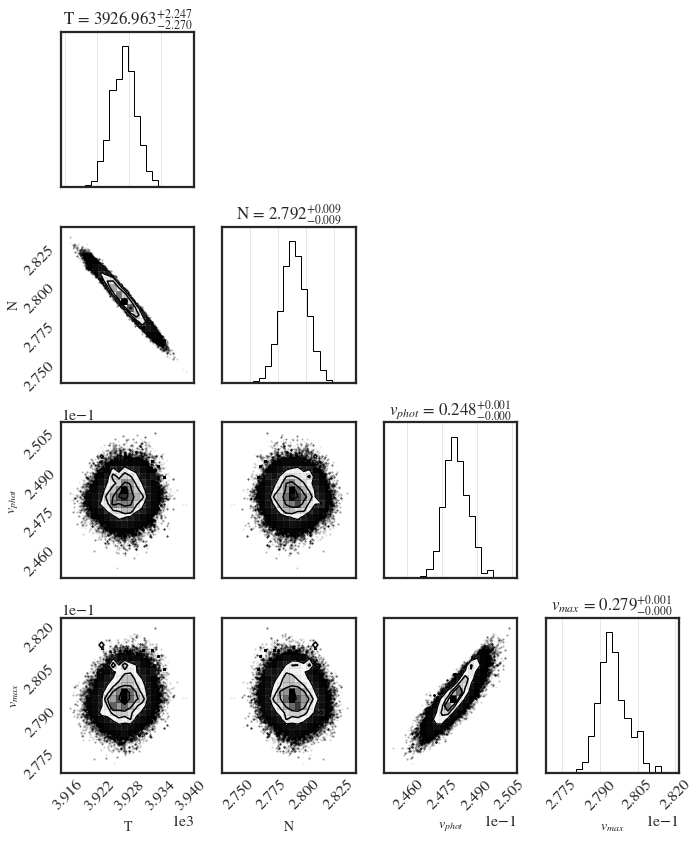

In [13]:
n_box = 4
fig,ax = plt.subplots(figsize=(10,12),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax']]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

plt.savefig('Pictures/OB2_covariance_small_2.png', dpi=300)